## Thalmic Labs Case Study


**Author**: Charley Carriero <br/>
**Date**: 19 June, 2018 <br/>


**The Task**: To identify a user from the motion pattern of their walking activity.
* Prepare a short presentation on your approach and results.
* Outline any business value you think could be created from this / similar data sets.  
* Comment on what kind of additional data points you would like to see to create more value. 

<br/>

In [116]:
## dependencies

import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

rcParams['figure.figsize'] = 15,8
%matplotlib inline  

<br/>

## The Data
---

In [14]:
## import data

allFiles = glob.glob('data/*.csv')
frame = pd.DataFrame()
list_ = []

i = 0 
for file in allFiles:
    temp = pd.read_csv(file, header=None)
    temp.columns = ["tstep", "xa", "ya", "za"]
    temp['uid'] =  i 
    list_.append(temp) 
    i = i + 1

frame = pd.concat(list_, ignore_index = True)

In [15]:
frame.head() #peek at data

,tstep,xa,ya,za,uid
0,0.000000,0.190680,6.5922,6.5514,0
1,0.029480,0.108960,5.8567,6.6604,0
2,0.061523,0.081722,6.7421,8.5808,0
3,0.099396,-1.116900,8.8941,7.0145,0
4,0.129670,0.612920,7.5048,5.6661,0


In [16]:
## talk about the fields, the units what they mean. 

## Exploratory Data Analysis (EDA)
---


In [17]:
n = len(frame['uid'].unique())
print("Number of users: ", n)

Number of users:  22


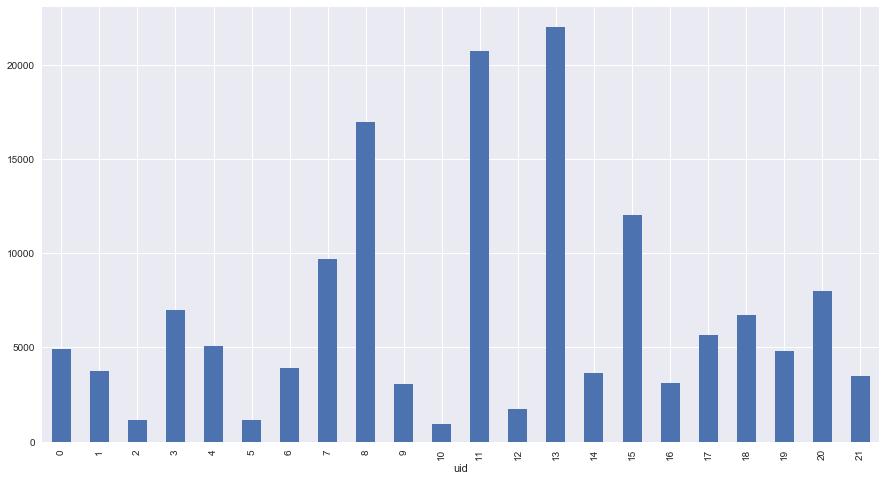

In [18]:
## how many time steps were recorded for each user?
rcParams['figure.figsize'] = 15,8
counts = frame.groupby('uid').size()
counts.plot.bar()

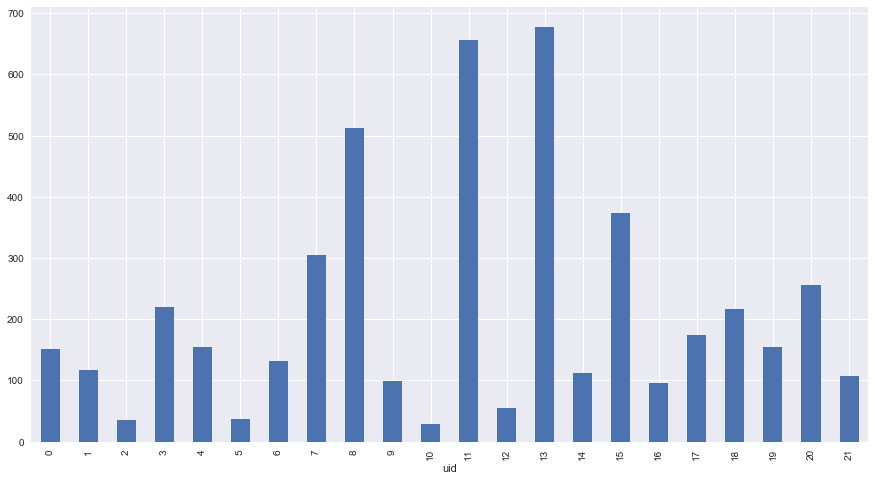

In [19]:
## how long was each participant recorded?
rcParams['figure.figsize'] = 15,8
max_times = frame.groupby("uid").max()["tstep"]
max_times.plot.bar()

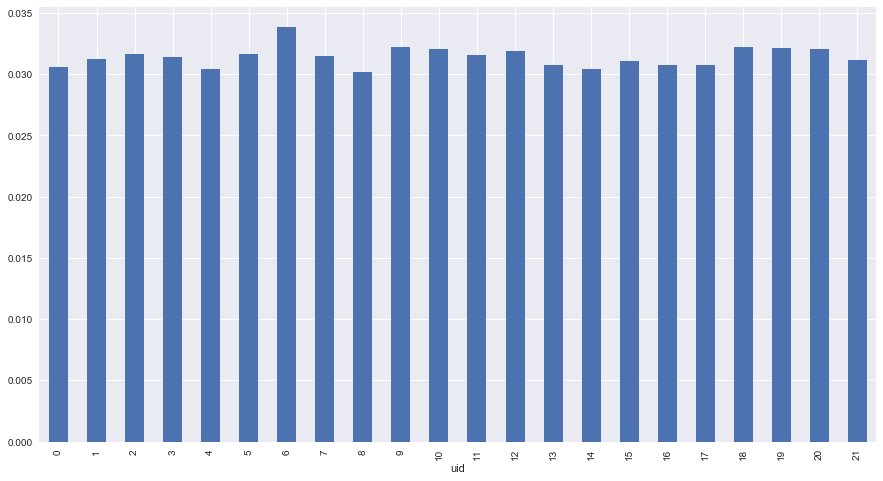

In [20]:
frame["tstep_lag"] = frame.groupby(['uid'])['tstep'].shift(1)
frame["msm_int"] = frame['tstep'] - frame['tstep_lag']
frame.groupby('uid').mean()['msm_int'].plot.bar()
rcParams['figure.figsize'] = 15,8

In [21]:
def plot_xyz(data, uid):
    '''
    Plot a given users x, y and z acceleration across the given time period
    '''
    user_subset = frame[frame.uid == uid]
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    ax1.plot(user_subset['tstep'], user_subset['xa'])
    ax1.set_title('X')
    ax2.plot(user_subset['tstep'], user_subset['ya'])
    ax2.set_title('Y')
    ax3.plot(user_subset['tstep'], user_subset['za'])
    ax3.set_title('Z')
    plt.suptitle('User %d' % uid)
    plt.xlabel('Seconds')
    rcParams['figure.figsize'] = 15,8

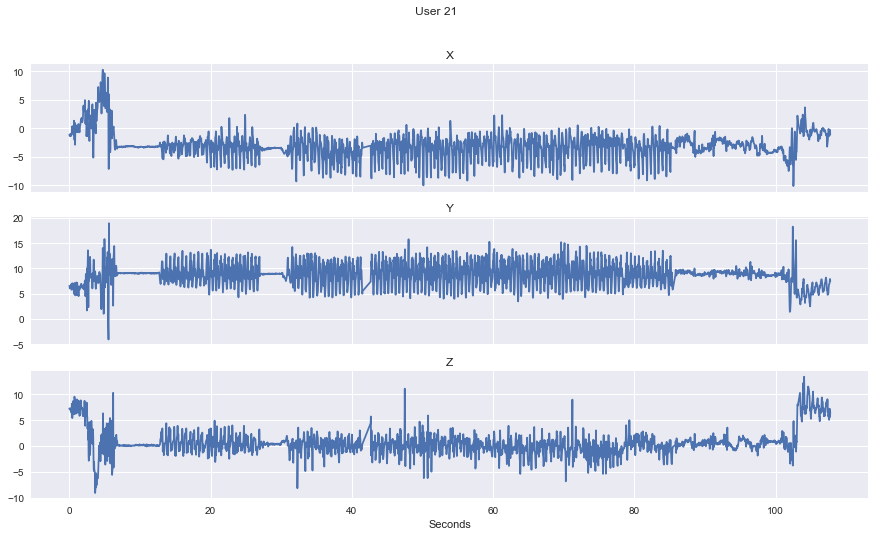

In [22]:
plot_xyz(frame, 21)

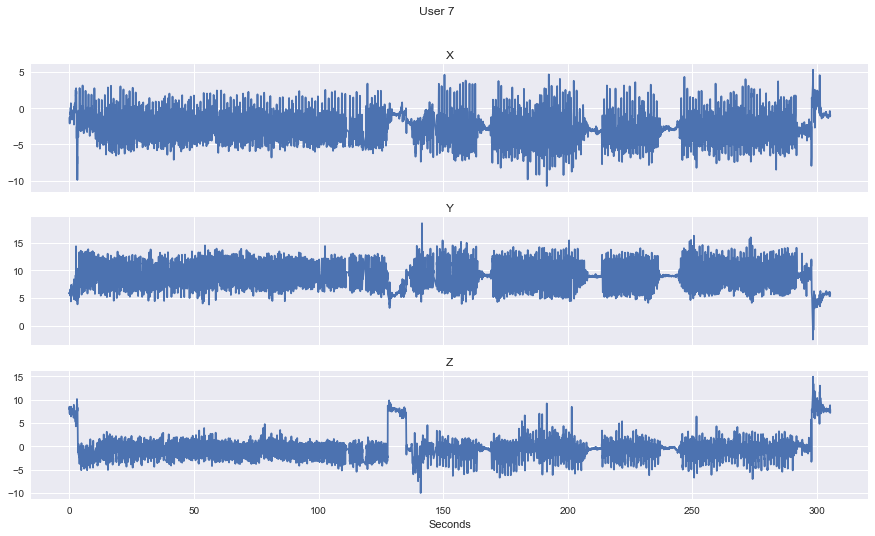

In [23]:
plot_xyz(frame, 7)

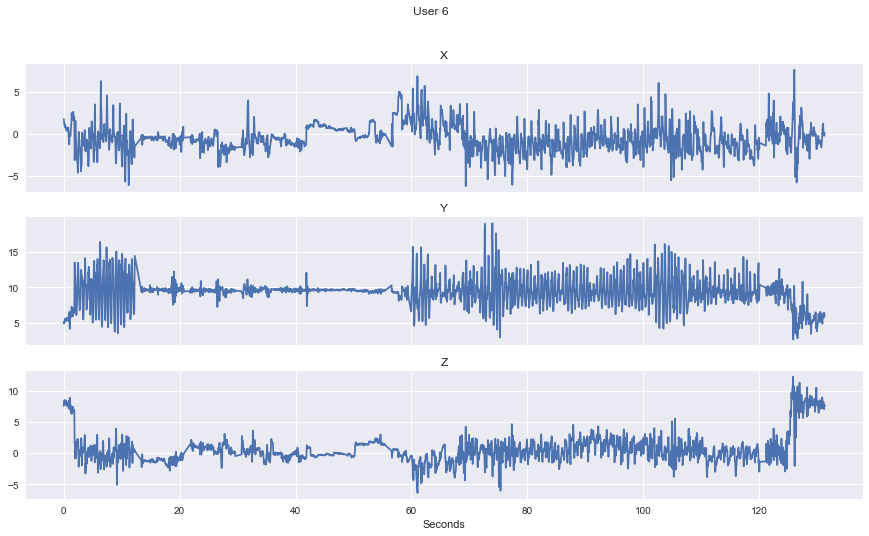

In [24]:
plot_xyz(frame, 6)

In [ ]:
## how does the EDA inspire the feature engineering? 
## what can we tell from these plots?

## Feature Engineering
---

In [31]:
# calculate resultant vector magnitude 

frame = frame[['tstep', 'xa', 'ya', 'za', 'uid']]                         # drop unnecessary columns

frame['rmag'] = frame.apply(
    lambda row: np.sqrt(row['xa']**2 + row['ya']**2 + row['za']**2),      # calculate
    axis=1
)
frame.head()

,tstep,xa,ya,za,uid,rmag
0,0.000000,0.190680,6.5922,6.5514,0,9.295929
1,0.029480,0.108960,5.8567,6.6604,0,8.869822
2,0.061523,0.081722,6.7421,8.5808,0,10.912961
3,0.099396,-1.116900,8.8941,7.0145,0,11.382253
4,0.129670,0.612920,7.5048,5.6661,0,9.423502


In [85]:
# define moving window and data wrangling functions

columns = ['xa','ya','za','rmag']

def get_rolling_window_stats(df, ws):
    a = df.rolling(ws).mean()
    b = df.rolling(ws).std()
    c = df.rolling(ws).max()
    d = df.rolling(ws).min()
    e = df.rolling(ws).median()

    df_new = pd.concat([a,b,c,d,e], axis=1)
    return(df_new)

def gen_col_names(col_names):
    new_names = []
    for col in col_names:
        new_names.append(col + "_mean")
        new_names.append(col + "_std")
        new_names.append(col + "_max")
        new_names.append(col + "_min")
        new_names.append(col + "_median")
    
    return(new_names)

def gen_user_features(user_df):
    
    user_features = pd.DataFrame() 

    for col in columns:                                         
        temp = get_rolling_window_stats(user_df[[col]], 100)
        user_features = pd.concat([user_features, temp], axis = 1)

    user_features.columns = gen_col_names(columns)
    return(user_features)

In [112]:
## generate features

features = pd.DataFrame()
for uid in frame['uid'].unique():                          # for each user (0:21)
    
    u = gen_user_features(frame[frame.uid == uid])         # generate features for that user
    u['uid'] = uid                                         # add a user identification field 
    features = pd.concat([features, u], axis = 0)          # concatinate row-wise to the new features df

features = features.dropna(axis = 0, how = 'any')          # drop any rows with NA values
features.index = range(len(features.index))                # reset the row index

In [115]:
## peek at features 

,xa_mean,xa_std,xa_max,xa_min,xa_median,ya_mean,ya_std,ya_max,ya_min,ya_median,...,za_std,za_max,za_min,za_median,rmag_mean,rmag_std,rmag_max,rmag_min,rmag_median,uid
0,3.405357,2.644126,7.7772,-1.3348,4.38575,7.380314,1.366564,11.223,2.7649,7.20520,...,3.575598,9.7249,-4.8216,4.27000,9.906634,1.327998,13.587444,6.902378,9.693372,0
1,3.462017,2.635236,7.7772,-1.3348,4.44025,7.391075,1.364531,11.223,2.7649,7.22560,...,3.606655,9.7249,-4.8216,4.19505,9.912507,1.326568,13.587444,6.902378,9.728584,0
2,3.518813,2.623418,7.7772,-1.3348,4.50155,7.412596,1.357037,11.223,2.7649,7.25965,...,3.629915,9.7249,-4.8216,4.18140,9.924322,1.322443,13.587444,6.902378,9.762111,0
3,3.559810,2.601102,7.7772,-1.3348,4.50155,7.427170,1.357589,11.223,2.7649,7.27330,...,3.654726,9.7249,-4.8216,4.14055,9.913617,1.318686,13.587444,6.902378,9.762111,0
4,3.610478,2.558075,7.7772,-1.3348,4.50155,7.422948,1.353632,11.223,2.7649,7.27330,...,3.702551,9.7249,-4.8216,4.00435,9.900956,1.310496,13.587444,6.902378,9.762111,0


<br/>

## Model Selection
---

In [144]:
# generate train and test set
X = features.drop('uid', axis=1)
y = features[['uid']]
print(X.shape)
print(y.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=1)

# reshape y 
ytrain = np.array(ytrain).reshape(ytrain.shape[0],)
ytest = np.array(ytest).reshape(ytest.shape[0],)

(147154, 20)
(147154, 1)


In [145]:
# random forest
rf = RandomForestClassifier()
rf.fit(Xtrain, ytrain)
print("train accuracy",rf.score(Xtrain,ytrain))
print("test accuracy",rf.score(Xtest,ytest))

train accuracy 1.0
test accuracy 0.9998414388293655


In [ ]:
# KNN
knn = KNeighborsClassifier()
knn.fit(Xtrain,ytrain)
print("train accuracy",knn.score(Xtrain,ytrain))
print("test accuracy",knn.score(Xtest,ytest))

<br/> 

## Model Assessment 
---

In [ ]:
## dummy classifier
## precision, recall f1, confusion matrix comparisons?